In [ ]:
import torch 
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

In [ ]:
data_train,data_val = random_split(dataset,(48000,12000))

In [ ]:
horizontal_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
])

In [ ]:
new_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=horizontal_transforms)

In [ ]:
og_data, _ = random_split(new_data,(48000,12000))

In [ ]:
h_data,bin = random_split(new_data,(9600,50400))

In [ ]:
horizontal_data = torch.utils.data.ConcatDataset((h_data, og_data))

In [ ]:
horizontal_data_train,horizontal_data_val = random_split(horizontal_data,(46080,11520))

In [ ]:
Rotation_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=30, interpolation=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:1303: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
new_data2 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=Rotation_transforms)

In [ ]:
og_data2, _2 = random_split(new_data2,(48000,12000))

In [ ]:
r_data,bin = random_split(new_data2,(9600,50400))

In [ ]:
rotation_data = torch.utils.data.ConcatDataset((r_data, og_data2))

In [ ]:
rotation_data_train,rotation_data_val = random_split(rotation_data,(46080,11520))

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
noise_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomApply([AddGaussianNoise(0., 1.)], p=0.5)

])

In [ ]:
new_data3 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=noise_transforms)

In [ ]:
og_data3, _3 = random_split(new_data3,(48000,12000))

In [ ]:
n_data,bin3 = random_split(new_data3,(9600,50400))

In [ ]:
noise_data = torch.utils.data.ConcatDataset((n_data, og_data3))

In [ ]:
noise_data_train,noise_data_val = random_split(noise_data,(46080,11520))

In [ ]:
augmented_data = torch.utils.data.ConcatDataset((data_train,h_data,r_data,n_data))

In [ ]:
augmented_data_train,augmented_data_val = random_split(augmented_data,(61440,15360))

In [ ]:
batch_size = 32

noise_train_dl = DataLoader(noise_data_train, batch_size=batch_size, shuffle=True)
rotation_train_dl = DataLoader(rotation_data_train, batch_size=batch_size, shuffle=True)
horizontal_train_dl = DataLoader(horizontal_data_train, batch_size=batch_size, shuffle=True)
augmented_train_dl = DataLoader(augmented_data_train, batch_size=batch_size, shuffle=True)


noise_val_dl = DataLoader(noise_data_val, batch_size=batch_size, shuffle=True)
rotation_val_dl = DataLoader(rotation_data_val, batch_size=batch_size, shuffle=True)
horizontal_val_dl = DataLoader(horizontal_data_val, batch_size=batch_size, shuffle=True)
augmented_val_dl = DataLoader(augmented_data_val, batch_size=batch_size, shuffle=True)

test_ds = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)




In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(20 * 7 * 7, 50)
        self.out = nn.Linear(784, 10)

    def forward(self, x):
        identity_out = x
        out = self.pool(F.relu(self.conv1(x)))
        out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 20 * 7 * 7)
        out = F.relu(self.fc(out))
        x = out
        output_size = 784
        padding_size = output_size - x.size(1)
        padded_x = torch.nn.functional.pad(x, (0, padding_size))
        out=padded_x
        out += identity_out.view(-1, 784)
        out = F.relu(out)
        out = self.out(out)

        return out


In [ ]:
lr = 0.0001
epochs = 20
model = Net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    
    # plot losses
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # plot accuracies
    axs[1].plot(train_accs, label='Training Accuracy')
    axs[1].plot(val_accs, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def train(lr, epochs, model, criterion, optimizer, save_path, train_dl ,val_dl) :
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  Softmax = nn.Softmax(dim=1)

  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0
      
      for i, data in enumerate(train_dl, 0):

          data2, labels = data[0], data[1]
          optimizer.zero_grad()
          output = model(torch.Tensor(data2))
          loss = criterion(output, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          predict = torch.argmax(Softmax(output),dim=1)
          correct=torch.sum(torch.eq(predict,labels)) 
          total = labels.size(0)
          correct += correct.item()
          total += total

      train_losses.append(running_loss/total)
      train_accs.append(100*correct/total)
              
      accuracy=100*correct/total
      print(f"Epoch - {epoch} :  Loss - {round(running_loss/total ,4)}, Accuracy - {accuracy}%")
      torch.save(model.state_dict(), f"{save_path}/epoch_{epoch}.pt")
      
      with torch.no_grad():
          model.eval()

          vsample, vcorrect = 0, 0
          for vdata, vlabel in val_dl:
              
              vsample += len(vdata)
              vpreds = model(vdata)
              vloss = criterion(vpreds, vlabel)
              vcorrect += torch.eq(Softmax(vpreds).argmax(dim=1), vlabel).sum().item()

          val_losses.append(vloss)
          val_accs.append((vcorrect/vsample)*100)

          
      print(f"Epoch - {epoch} : Validation Loss - {vloss}, Validation Accuracy - {round((vcorrect/vsample)*100, 4)}")


  plot_metrics(train_losses, val_losses, train_accs, val_accs)


In [ ]:
def test (test_dl,ckpts,model,criterion) : 

  softmax = nn.Softmax(dim=1)


  model.load_state_dict(torch.load(f"{ckpts}"))

  with torch.no_grad():
          model.eval()

          vsample, vcorrect = 0, 0
          for vdata, vlabel in test_dl:
              
              vsample += len(vdata)
              
              vpreds = model(vdata)
              vloss = criterion(vpreds, vlabel)
              
              vcorrect += torch.eq(softmax(vpreds).argmax(dim=1), vlabel).sum().item()

          
  print(f"Test Accuracy - {round((vcorrect/vsample)*100, 4)}")


Epoch - 0 :  Loss - 25.6597, Accuracy - 71.875%
Epoch - 0 : Validation Loss - 0.3982808291912079, Validation Accuracy - 78.0556
Epoch - 1 :  Loss - 14.0836, Accuracy - 87.5%
Epoch - 1 : Validation Loss - 0.3805385231971741, Validation Accuracy - 80.625
Epoch - 2 :  Loss - 12.1167, Accuracy - 96.875%
Epoch - 2 : Validation Loss - 0.46906861662864685, Validation Accuracy - 83.6372
Epoch - 3 :  Loss - 10.6255, Accuracy - 84.375%
Epoch - 3 : Validation Loss - 0.5679216980934143, Validation Accuracy - 85.5729
Epoch - 4 :  Loss - 9.4051, Accuracy - 90.625%
Epoch - 4 : Validation Loss - 0.34439316391944885, Validation Accuracy - 87.2396
Epoch - 5 :  Loss - 8.7617, Accuracy - 90.625%
Epoch - 5 : Validation Loss - 0.32032692432403564, Validation Accuracy - 87.1701
Epoch - 6 :  Loss - 8.0466, Accuracy - 100.0%
Epoch - 6 : Validation Loss - 0.20360030233860016, Validation Accuracy - 87.9601
Epoch - 7 :  Loss - 7.7984, Accuracy - 78.125%
Epoch - 7 : Validation Loss - 0.32722821831703186, Validatio

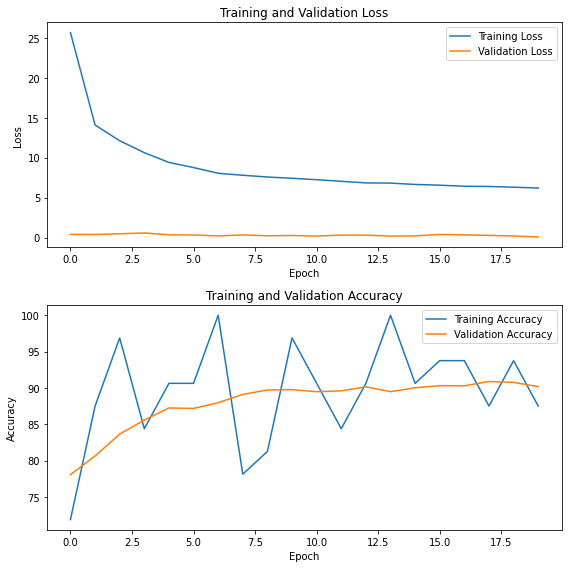

In [ ]:
train(lr, epochs, model, criterion, optimizer, "/content/gdrive/MyDrive/MyData/1/", noise_train_dl ,noise_val_dl)

Epoch - 0 :  Loss - 3.6888, Accuracy - 100.0%
Epoch - 0 : Validation Loss - 0.01913182996213436, Validation Accuracy - 95.7812
Epoch - 1 :  Loss - 2.8418, Accuracy - 100.0%
Epoch - 1 : Validation Loss - 0.04242769628763199, Validation Accuracy - 96.5017
Epoch - 2 :  Loss - 2.4713, Accuracy - 93.75%
Epoch - 2 : Validation Loss - 0.012727883644402027, Validation Accuracy - 96.5885
Epoch - 3 :  Loss - 2.2344, Accuracy - 96.875%
Epoch - 3 : Validation Loss - 0.1140318214893341, Validation Accuracy - 96.9618
Epoch - 4 :  Loss - 2.0473, Accuracy - 93.75%
Epoch - 4 : Validation Loss - 0.07797273248434067, Validation Accuracy - 97.2569
Epoch - 5 :  Loss - 1.9177, Accuracy - 100.0%
Epoch - 5 : Validation Loss - 0.19566777348518372, Validation Accuracy - 97.6389
Epoch - 6 :  Loss - 1.7979, Accuracy - 100.0%
Epoch - 6 : Validation Loss - 0.23094892501831055, Validation Accuracy - 97.4479
Epoch - 7 :  Loss - 1.667, Accuracy - 100.0%
Epoch - 7 : Validation Loss - 0.009633030742406845, Validation Ac

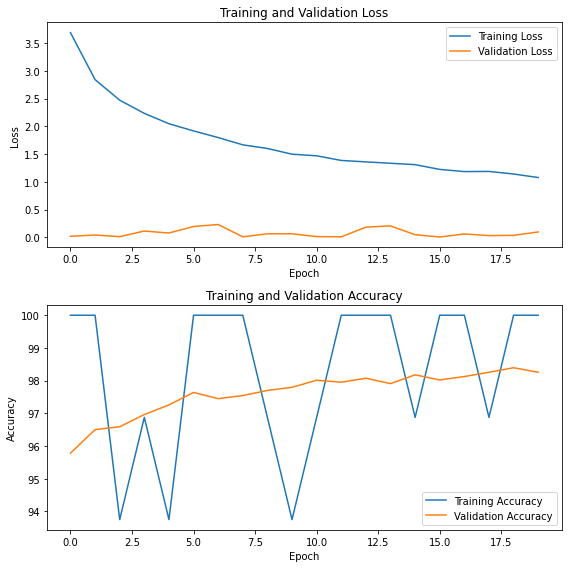

In [ ]:
train(lr, epochs, model, criterion, optimizer, "/content/gdrive/MyDrive/MyData/2/", rotation_train_dl, rotation_val_dl)

Epoch - 0 :  Loss - 5.9945, Accuracy - 90.625%
Epoch - 0 : Validation Loss - 0.16127179563045502, Validation Accuracy - 95.1302
Epoch - 1 :  Loss - 3.0272, Accuracy - 96.875%
Epoch - 1 : Validation Loss - 0.027692943811416626, Validation Accuracy - 96.4236
Epoch - 2 :  Loss - 2.4316, Accuracy - 100.0%
Epoch - 2 : Validation Loss - 0.017044201493263245, Validation Accuracy - 96.849
Epoch - 3 :  Loss - 2.0701, Accuracy - 100.0%
Epoch - 3 : Validation Loss - 0.12368626892566681, Validation Accuracy - 97.474
Epoch - 4 :  Loss - 1.8002, Accuracy - 100.0%
Epoch - 4 : Validation Loss - 0.1837257444858551, Validation Accuracy - 97.7865
Epoch - 5 :  Loss - 1.6101, Accuracy - 96.875%
Epoch - 5 : Validation Loss - 0.08223326504230499, Validation Accuracy - 97.8733
Epoch - 6 :  Loss - 1.4913, Accuracy - 96.875%
Epoch - 6 : Validation Loss - 0.18688321113586426, Validation Accuracy - 97.8212
Epoch - 7 :  Loss - 1.3818, Accuracy - 100.0%
Epoch - 7 : Validation Loss - 0.04588278383016586, Validation 

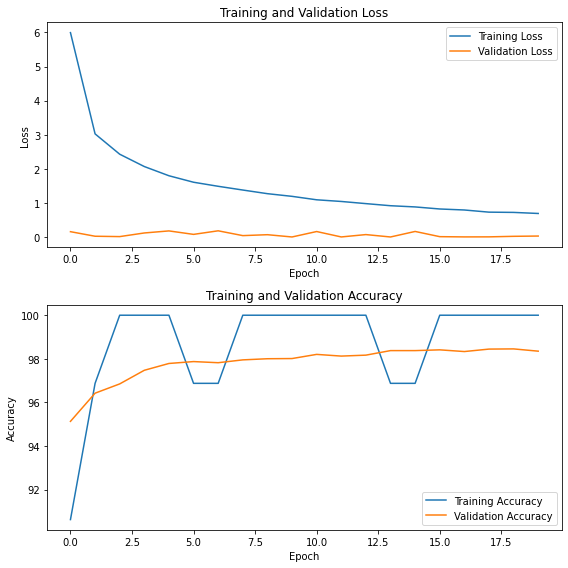

In [ ]:
train(lr, epochs, model, criterion, optimizer, "/content/gdrive/MyDrive/MyData/3/", horizontal_train_dl, horizontal_val_dl)

Epoch - 0 :  Loss - 4.0955, Accuracy - 96.875%
Epoch - 0 : Validation Loss - 0.09492632001638412, Validation Accuracy - 96.7188
Epoch - 1 :  Loss - 3.1266, Accuracy - 96.875%
Epoch - 1 : Validation Loss - 0.2447298914194107, Validation Accuracy - 96.8099
Epoch - 2 :  Loss - 2.8342, Accuracy - 100.0%
Epoch - 2 : Validation Loss - 0.004943787585943937, Validation Accuracy - 97.1029
Epoch - 3 :  Loss - 2.6549, Accuracy - 90.625%
Epoch - 3 : Validation Loss - 0.19128209352493286, Validation Accuracy - 97.1745
Epoch - 4 :  Loss - 2.4542, Accuracy - 96.875%
Epoch - 4 : Validation Loss - 0.20537002384662628, Validation Accuracy - 97.2656
Epoch - 5 :  Loss - 2.4189, Accuracy - 90.625%
Epoch - 5 : Validation Loss - 0.08544977754354477, Validation Accuracy - 97.1484
Epoch - 6 :  Loss - 2.317, Accuracy - 100.0%
Epoch - 6 : Validation Loss - 0.04267319664359093, Validation Accuracy - 97.2591
Epoch - 7 :  Loss - 2.2377, Accuracy - 100.0%
Epoch - 7 : Validation Loss - 0.03073914349079132, Validation

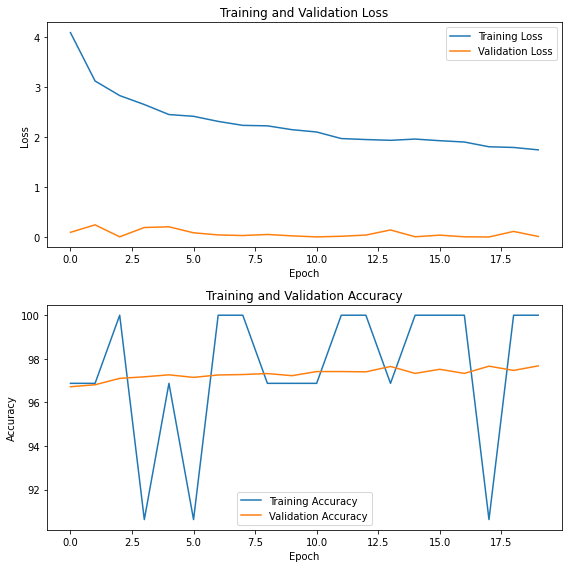

In [ ]:
train(lr, epochs, model, criterion, optimizer, "/content/gdrive/MyDrive/MyData/4/", augmented_train_dl, augmented_val_dl)

In [ ]:
test(test_dl,"/content/gdrive/MyDrive/MyData/1/epoch_17.pt",model,criterion)

Test Accuracy - 97.73


In [ ]:
test(test_dl,"/content/gdrive/MyDrive/MyData/2/epoch_18.pt",model,criterion)

Test Accuracy - 98.6


In [ ]:
test(test_dl,"/content/gdrive/MyDrive/MyData/3/epoch_18.pt",model,criterion)

Test Accuracy - 98.48


In [ ]:
test(test_dl,"/content/gdrive/MyDrive/MyData/4/epoch_19.pt",model,criterion)

Test Accuracy - 99.07
